<a href="https://colab.research.google.com/github/ericbill21/siemens/blob/master/Siemens_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Imports and config

# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
from psutil import virtual_memory

# Arithmetic Operations
import pandas as pd
import numpy as np
import random
import math

# Data visualization
from matplotlib import pyplot as plt
plt.style.use('default')

# Progress calculation
import sys
import time
from datetime import date

# Time prediciton
PREV_TIME = 0
PB_START_TIME = 0

# Mounting Google drive
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
#@title GPU and RAM info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
#   print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#   print('re-execute this cell.')
# else:
#   print('You are using a high-RAM runtime!')

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
#@title Global constants

# Dictionaries
COLORS = {0 : 'green', 1 : 'red', 'green' : 0, 'red' : 1}
SOURCES = {'A' : 'https://drive.google.com/file/d/1hAzAKZNpmSclSI7HnV_cRjpMS4Kh5r1q/view?usp=sharing', 'B' : 'https://drive.google.com/file/d/12VlecL-5iYs-BFpnTOba1x65jWofBX1P/view?usp=sharing', 'C' : 'https://drive.google.com/file/d/1-Z0RuJIi1cZcqrrmV6TqT0O1PwI2OiBY/view?usp=sharing'}
SOURCE_SIZE = {'A': 1000,'B' : 5000, 'C' : 50000}

CURRENT_SET = 'A'

# Balancing dataset to threshold
THRESHOLD_DATA = 0.4

# Threshold for balanced validation set
THRESHOLD_VAL = 0.4

# Random number seed
random.seed(time.time())

# Examlpe subsets of each dataset
#subsetA = [47, 847, 993, 55, 102, 572, 430, 115, 842, 72, 770, 107, 78, 834, 593, 43, 234, 709, 210, 378]
#subsetB = [606, 2663, 1809, 2145, 4539, 3333, 3562, 2262, 512, 2046, 1541, 909, 286, 4815, 3663, 1742, 2822, 2756, 2937, 3080, 3845, 3949, 2506, 3984, 2803, 2067]
#subsetC = [32088, 33534, 39634, 40177, 25142, 752, 41771, 11793, 16415, 3811, 2096, 35902, 42221, 19594, 25109, 40476, 25162, 41150, 34610, 28329, 46339, 43149, 44441, 25720, 38747, 49497, 12708, 23920, 2280, 17946]

subsetA = random.sample(range(1000), 150)
subsetB = random.sample(range(5000), 800)
subsetC = random.sample(range(50000), 8000)

VAL_INDICES = locals()['subset' + CURRENT_SET]

# Penalty applied to false green classifications in custom loss function
PENALTY = 0.2

In [5]:
#@title Functions
def getDataSet():
  """Returns the dataset currently selected by CURRENT_SET."""
  path = 'https://drive.google.com/uc?export=download&id='+SOURCES[CURRENT_SET].split('/')[-2]
  return pd.read_excel(path)
  

def makePlot(dataSet = np.array([]), correct_pred_points = np.array([]),
             incorrect_pred_points = np.array([]), figsize=(14,10)):
  """"Plots green and red points and markers as scatter graph.
  
  Args:
    dataSet: pandas.DataFrame, optional
      Dataframe with columns 'x_i1', 'x_i2', 'l_i1'. Dataset to be plotted.
      Defaults to dataset selected by CURRENT_SET.
    correct_pred_points: 2-D list, optional 
      List of shape (x,2) containing correctly predicted points. Marked as black
      'x' on scatter graph.
    incorrect_pred_points: 2-D list, optional 
      List of shape (x,2) containing incorrectly predicted points. Marked as
      black '*' on scatter graph.
    figsize: 2-tuple of floats
      (x,y) where x is width and y is height of figure in inches.
  
  Raises:
    TypeError: If dataSet is not an instance of pd.DataFrame or the other
      parameters do not have the required shape.
  """
  # Preparing optional parameters
  if dataSet.shape == (0,):
    dataSet = getDataSet()
  if isinstance(correct_pred_points, list):
    correct_pred_points = np.array(correct_pred_points)
  if isinstance(incorrect_pred_points, list):
    incorrect_pred_points = np.array(incorrect_pred_points)

  # Checking for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be ' +
                    f'{pd.DataFrame}')

  # Checking for the right shape 
  if (correct_pred_points.shape != (correct_pred_points.shape[0],2)
      and np.array(correct_pred_points).shape != (0,)):
    raise TypeError(f'The shape of the parameter correct_pred_points is: \
      {np.array(correct_pred_points).shape}, but it should be 2 dimensional')
  
  if (incorrect_pred_points.shape != (incorrect_pred_points.shape[0],2)
      and np.array(incorrect_pred_points).shape != (0,)):
    raise TypeError(f'The shape of the parameter incorrect_pred_points is: \
      {np.array(incorrect_pred_points).shape}, but it should be 2 dimensional')
  
  # Creating a subplot
  fig, ax = plt.subplots(figsize=figsize)

  # Scattering all points
  x = dataSet['x_i1']
  y = dataSet['x_i2']
  c = [COLORS[i] for i in dataSet['l_i']] 

  ax.scatter(x, y, c=c)

  # Adding markers to the specified points
  if correct_pred_points.shape[0] > 0:
    ax.scatter(correct_pred_points[:, 0], correct_pred_points[:, 1],
              marker = "x", c = 'black', label='correct')
  if incorrect_pred_points.shape[0] > 0:
    ax.scatter(incorrect_pred_points[:, 0], incorrect_pred_points[:, 1],
            marker = "*", c = 'black', label='incorrect')

  if correct_pred_points.shape[0] > 0 or incorrect_pred_points.shape[0] > 0:
    plt.legend()

  # Setting parameters for ploting
  plt.xlabel('x_i1')
  plt.ylabel('x_i2')
  plt.title(f'DataSet {CURRENT_SET}')
  plt.axis('scaled')
  plt.show()



def seperateValidationSet(dataSet, validationIndices):
  """Formats a subset of points from a dataset as validation points.

  Validation points are extracted and deleted from dataSet to be used for
  validation later on.

  Args:
    dataSet: pandas.DataFrame, optional
      Dataframe with columns 'x_i1', 'x_i2', 'l_i1'. Dataset which the
      validation points are extracted from.
    validationIndices: 1-D list of ints
      The elements corresponding to these indices are extracted from dataSet.

  Returns: 2-tuple of the form (valSet_points, valSet_labels), where valSet_points
    is a tensor of shape (x,2) and valSet_labels is a tensor of shape (x,1).
  """
  # Checking for the right type
  if not isinstance(dataSet, pd.DataFrame):
    raise TypeError(f'dataSet is of type: {type(dataSet)}, but should be \
      {pd.DataFrame}')

  # Checking for the right shape 
  if len(np.array(validationIndices).shape) != 1:
    raise TypeError(f'The shape of the parameter validationIndices is: \
      {np.array(validationIndices).shape}, but it should be 1 dimensional')
  
  valSet_points = dataSet[['x_i1','x_i2']].loc[validationIndices]
  valSet_labels = dataSet['l_i'].loc[validationIndices]
  
  # Saving the validation points
  valSet_points = np.array(valSet_points)
  valSet_labels = np.array(valSet_labels).astype('float')

  # Removing the validation point
  dataSet.drop(index=validationIndices, inplace=True)
  dataSet.reset_index(inplace=True)

  return (valSet_points, valSet_labels)



def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1,
                     length = 100, fill = '█'):
  """Prints a progress bar.

  Args:
    iteration: int
      Current progress step as. (iteration/total progress).
    total: int
      Total progress steps until completion.
    prefix: str, optional
      Printed infront of the progress bar.
    suffix: str, optional
      Printed behind ETA.
    decimals: int, optional
      Number of decimal places of percentage progress.
    length: int, optional
      Length of the progress bar in characters.
    fill: char, optional
      Filler of the progress bar.
  """
  # Preparing strings
  percentage_progress = (100*(iteration/float(total)))
  percent = ("{0:." + str(decimals) + "f}").format(percentage_progress)
  filledLength = int(length * iteration // total)
  bar = fill * filledLength + '-' * (length - filledLength)

  # Bob's alternative time calculation
  if iteration == 0:
    global PB_START_TIME
    PB_START_TIME = time.time()
    time_so_far = 0
    time_remaining = 0
  else:
    time_so_far = time.time() - PB_START_TIME
    time_remaining = time_so_far/percentage_progress * (100-percentage_progress)

  sys.stdout.write(f'\r{prefix} |{bar}| {percent}% | ETA: {round((time_remaining/60), 2)} minutes | {suffix}')
  sys.stdout.flush()

  # Erease progress bar on complete
  if iteration == total:
    global PREV_TIME
    PREV_TIME = 0
    sys.stdout.write('\r')
    sys.stdout.flush()



def makeCertaintyMap(model, accuracy = 100, specific_color = None):
  """Visualizes the prediction certainty of the model for a grid of data points.

  All data points have x and y values between 0 and 1. 

  Args:
    model: keras model
      The model who's certainty is to be visualized.
    accuracy: int, optional
      Data points are spaced 1/accuracy apart along the x and y axis. The grid
      of data points plotted has the dimension accuracy*accuracy.
    specific_color:0 or 1, optional
      If 0, plots the model's certainty that a data point is green for all
      points in the grid. If 1, analogously for red. 

  Raises:
    TypeError: If specific_color is not 'None', '0' or '1', or if accuracy is not
      an int.
  """
  # Exceptions
  if specific_color != None:
    if specific_color != 0 and specific_color != 1:
      raise TypeError(f'Invalid value for specific_color. Value is {specific_color}, \
        but should be "None", "0" or "1".')

  if not isinstance(accuracy, int):
    raise TypeError(f'Invalid type for accuracy. Type is {type(accuracy)}, but \
      should be int.')

  accuracy_map = np.zeros((accuracy, accuracy))

  for i in range(accuracy):
    array = np.array([[j/accuracy, i/accuracy] for j in range(accuracy)])
    result = model.predict(array)

    if specific_color != None:
      # Saving the prediction for the specified color
      accuracy_map[i] = result[:, specific_color]
    
    else:
      result = result.max(axis=1) #Getting each max value

      #Normalize the values which are between 0.5 <-> 1 to 0 <-> 1
      normalized = (result-0.5)/0.5
      accuracy_map[i] = normalized
  
    # Print current progress
    printProgressBar(i, accuracy-1)

  if specific_color != None:
    plt.title(f'Certaintiy for {COLORS[specific_color]}')
  else:
    plt.title(f'General Certainty')

  plt.imshow(accuracy_map, origin='lower', cmap='tab20b', vmin=0, vmax=1)
  plt.colorbar()
  plt.show()
  return accuracy_map



def timeCalc():
  """Calculates time between previous call and current call.

  Returns:
    Time difference in minutes as float.
  """
  global PREV_TIME
  if PREV_TIME == 0:
    PREV_TIME = time.time()
    return 0
  
  res = (time.time() - PREV_TIME) / 60
  PREV_TIME = time.time()
  return res



def plotLoss(history):
  """Plots training loss and validation loss with respect to training epochs.

  Args:
    history: keras History
      history of keras model.
  """
  if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])

  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()



def showPredicitons(model, history, valSet_points,
                    valSet_labels, showCorrectPoints=False):
  """Visualizes the predictions for the validation points.

  Args:
    model: keras model
      Model which performs the predictions.
    history: keras History
      history of keras model.
    valSet_points: 2-D array of shape (x,2)
      Data points used for validation.
    valSet_labels: 1-D array of shape (x,)
      Ground truth labels of the validation points.
    showCorrectPoints: boolean, optional
      Whether correctly classified points should be marked as black 'x' or not.

  Returns:
    2-dimensional numpy array of shape (x,2) with the predictions for the
    validation points.
  """
  # Predict the validation points
  prediction = model.predict(valSet_points)

  # Identifying correctly and incorrectly classified points
  correct_indices = np.where((valSet_labels == np.argmax(prediction, axis=1)) == True)
  incorrect_indices = np.where((valSet_labels == np.argmax(prediction, axis=1)) == False)

  number_of_points = np.bincount(np.argmax(prediction, axis=1))

  total_misclassifications = np.bincount(valSet_labels == np.argmax(prediction, axis=1))[0]
  red_misclassifications = len(np.where(valSet_labels[incorrect_indices] == 1)[0])
  green_misclassifications = len(np.where(valSet_labels[incorrect_indices] == 0)[0])

  #Average misclassification certainty
  misclass_certainties = []
  for i in incorrect_indices[0]:
    misclass_certainties.append(np.max(prediction[i]))
  avg_misclass_certainty = sum(misclass_certainties)/total_misclassifications
  
  print('Validation accuracy: {:.2f}%'.format((history.history['val_accuracy'])[-1]*100))
  print(f'Predictions for green: {number_of_points[0]} / {len(valSet_labels)}')
  print(f'Predictions for red: {number_of_points[1]} / {len(valSet_labels)}')
  print(f'Points misclassified: {total_misclassifications}')
  print(f'Red points misclassified: {red_misclassifications}')
  print(f'Green points misclassified: {green_misclassifications}')
  print('Average misclassification certainty: {:.2f}'.format(avg_misclass_certainty))

  if showCorrectPoints:
    makePlot(correct_pred_points=valSet_points[correct_indices],
           incorrect_pred_points=valSet_points[incorrect_indices])
  else:
    makePlot(incorrect_pred_points=valSet_points[incorrect_indices])
    
  # Make bar graph showing red and green misclassifications
  bars = ('Red', 'Green')
  height = [red_misclassifications, green_misclassifications]
  x_pos = np.arange(len(bars))

  fig, ax = plt.subplots()
  ax.bar(x_pos, height, width=0.35, color=['red', 'green'])

  ax.set_ylabel('Misclassifications')
  ax.set_title('Misclassifications by color')
  ax.set_xticks(x_pos)
  ax.set_xticklabels(bars)

  rects = ax.patches # Array of bars

  labels = [red_misclassifications, green_misclassifications]

  for rect, label in zip(rects, labels): # Add labels above bars
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height, label,
              ha='center', va='bottom')

  plt.show()
  
  return prediction

  

def balanceDataset(dataSet, threshold, verbose=1):
  """Artificially balances dataSet by duplicating red or green points.

  Args: 
    dataSet: pandas.DataFrame, optional
      Dataframe with columns 'x_i1', 'x_i2', 'l_i1'. The datset to be balanced.
    threshold: float between 0 and 0.5
      The function duplicates red or green points until the fraction of points
      of the less frequent color is at least equal to the threshold.

  Returns:
    pandas.DataFrame with columns 'x_i1', 'x_i2', 'l_i1'.
  """
  total_number_of_points = dataSet.shape[0]
  number_of_green_points = dataSet.loc[dataSet["l_i"] == 0].shape[0]
  number_of_red_points = dataSet.loc[dataSet["l_i"] == 1].shape[0]

  amount = 0

  if number_of_red_points / total_number_of_points < threshold:
    amount = int( (threshold * total_number_of_points - number_of_red_points) // (1 - threshold) )
    red_points = dataSet.loc[dataSet['l_i'] == 1] #Getting all red points
    chosen_points = red_points.sample(amount, replace=True) #Selecting a random subset of red points
    dataSet = dataSet.append(chosen_points, ignore_index=True) #appending the subset

  if number_of_green_points / total_number_of_points < threshold:
    amount = int( (threshold * total_number_of_points - number_of_green_points) // (1 - threshold) )
    green_points = dataSet.loc[dataSet['l_i'] == 0] #Getting all green points
    chosen_points = green_points.sample(amount, replace=True) #Selecting a random subset of green points
    dataSet = dataSet.append(chosen_points, ignore_index=True) #appending green subset

  dataSet = dataSet[['x_i1','x_i2','l_i']]

  total_number_of_points = dataSet.shape[0]
  number_of_green_points = dataSet.loc[dataSet["l_i"] == 0].shape[0]
  number_of_red_points = dataSet.loc[dataSet["l_i"] == 1].shape[0]

  if verbose > 0:
    print(f'Artificially exended by {amount} points')
    print(f'Relation is now: {round(number_of_green_points / total_number_of_points, 2)}',
            f'green : {round(number_of_red_points / total_number_of_points, 2)} red ')
  
  return dataSet



def calculatePenaltyEffect(model, x, y, validation_data, interval=(0,1), accuracy=10, 
                      batch_size=32, epochs=200, verbose=0):
  """Calculates red, green, and total misclassifications in relation to penalty.

  Args:
    model: keras model
      Model for which the penalty effect is measured.
    x: tensor of shape (x,2) and type tf.float32
      Training points.
    y: tensor of shape (x,1) and type float32
      Training labels.
    validation_data: 2-tuple
      (valSet_points, valSet_labels) where valSet_points is a tensor of shape
      (x,2) and type tf.float32 and valSet_labels tensor of shape (x,1) and type
      tf.float32. Validation points and labels.
    interval: 2-tuple, optional
      (x,y) which defines the penalty interval plotted. x is the lowest penalty,
      y the highest.
    accuracy: int, optional
      Penalty interval is evenly split into 'accuracy' many points.
    verbose: boolean, optional
      Whether to print progress bar and plot results or not. 
    All others: optional
      See tf.keras.Model.

  Returns:
    3-tuple of int lists (total_misclass_percentage, red_misclass_percentage, 
    green_misclass_percentage).
  """
  total_misclass_percentages = []
  red_misclass_percentages = []
  green_misclass_percentages = []
  penalties = np.zeros(accuracy + 1)
  increments = (interval[1]-interval[0])/accuracy

  points = validation_data[0]
  labels = validation_data[1].astype(int)

  number_of_points = len(labels)
  red_points = len(np.where(labels==1)[0])
  green_points = len(np.where(labels==0)[0])

  if verbose > 0:
    printProgressBar(0, accuracy+1)

  # MAIN LOOP
  for i in range(accuracy+1):
    penalty = interval[0] + (interval[1]-interval[0])*(i/accuracy)
    model.set_weights(initialWeights)

    model.compile(optimizer='adam', loss=construct_custom_penalty_loss(penalty),
                  metrics=['accuracy']) # Compile model with penalty

    history = model.fit(x, y, batch_size, epochs, verbose=0,
                        validation_data=validation_data)

    prediction = model.predict(validation_data[0])

    correct_indices = np.where((labels == np.argmax(prediction, axis=1)) == True)
    incorrect_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

    total_misclassifications = np.bincount(labels == np.argmax(prediction, axis=1))[0]
    red_misclassifications = len(np.where(labels[incorrect_indices] == 1)[0])
    green_misclassifications = len(np.where(labels[incorrect_indices] == 0)[0])

    total_misclass_percentages.append((total_misclassifications/number_of_points)*100)
    red_misclass_percentages.append((red_misclassifications/red_points)*100)
    green_misclass_percentages.append((green_misclassifications/green_points)*100)

    penalties[i] = penalty
    
    if verbose > 0:
      printProgressBar(i+1, iterations+1)

  # PLOTTING RESULTS
  if verbose > 0:
    plt.figure(figsize=(20,15))
    plt.plot(penalties, total_misclass_percentages, 'b', penalties, 
              red_misclass_percentages, 'r', penalties, green_misclass_percentages,
              'g')
    plt.title(f'Dataset {CURRENT_SET}: Misclassification by penalty')
    plt.ylabel('% misclassified')
    plt.xlabel('Penalty')
    plt.xticks(np.arange(interval[0], interval[1]+increments, increments))
    plt.legend(['total', 'red', 'green'], loc='upper left')
    plt.show()

  return (total_misclass_percentages, red_misclass_percentages,
         green_misclass_percentages)



def KNN(dataSet, point, k, significance=0.1, increment=0.05, show_plot=True):
  """ K-nearest neighbor classifier.

  Statistical classifier. Uses the k nearest neighbors to predict the color of a
  given point by comparing the number of neighbours of each color and weigthing
  them with their squared distance to the point.

  Args:
    dataSet: pandas.DataFrame, optional
      Dataframe with columns 'x_i1', 'x_i2', 'l_i1'. Dataset to be used for
      calculation. Defaults to dataset selected by CURRENT_SET.
    point: Array in the form of [x_i1, x_i2]
    k: Positive int
      Number of neighbours taken into account for classification
    significance: float between 0 and 1, optional
      Start search radius.
    increment: float between 0 and 1, optional
      Amount of increment of the search radius while gathering k neighbours.
    show_plot: boolean, optional
      If 'True' the function plots the dataset and the selected neighbours.

  Returns:
    A 2-tuple with the predictions for each class. 
    (prediction_green, prediction_red)
  """
  # Gathering points until at least k neighbours are found 
  neighb = np.array([])
  while significance <= 1 and neighb.shape[0] < k:
      neighb = dataSet.loc[(dataSet['x_i1'] - point[0])**2 +
                           (dataSet['x_i2'] -point[1])**2 <= significance**2]
      significance += increment
  
  # Reindexing
  neighb = neighb.reset_index()

  # Calculating the distances of each neighbour to the target point
  dist = np.zeros(neighb.shape[0])
  for i in range(neighb.shape[0]):
    dist[i] = (neighb['x_i1'].loc[i] - point[0])**2 + (neighb['x_i2'].loc[i] -
                                                       point[1])**2

  # Removing all overhang neighbours until there are only k
  while neighb.shape[0] > k:
    neighb = neighb.drop(np.argmax(dist))
    dist[np.argmax(dist)] = -1

  # Reindexing
  dist = np.zeros(neighb.shape[0])
  neighb = neighb.reset_index()

  # Calculating the distances of each neighbour to the target point
  for i in range(neighb.shape[0]):
    dist[i] = (neighb['x_i1'].loc[i] - point[0])**2 + (neighb['x_i2'].loc[i] -
                                                       point[1])**2


  pred_g = 0
  pred_r = 0

  # Sum the neighbours of each color with the weight 1-dist^2 
  for i in range(neighb.shape[0]):
    if neighb['l_i'].loc[i] == 0:
      pred_g += (1 - dist[i])
    elif neighb['l_i'].loc[i] == 1:
      pred_r += (1 - dist[i])

  # Normalize
  sum = pred_g + pred_r
  pred_g = pred_g // sum
  pred_r = pred_r // sum

  # Plot neighbours 
  if show_plot:
    selected_neighb = [[neighb['x_i1'].loc[i], neighb['x_i2'].loc[i]]
                       for i in range(neighb.shape[0])]
    makePlot(dataSet, [point], selected_neighb)
    print(f'Prediction for green: \t{pred_g}')
    print(f'Prediction for red: \t{pred_r}')

  return (pred_g, pred_r)



def makeCertaintyMapKNN(k, accuracy = 100, specific_color = None):
  """Visualizes the prediction certainty of K-nearest-neighbour algorithm for a grid of data points.

  All data points have x and y values between 0 and 1. 

  Args:
    k: postive int
      The number of neighbours specified for the KNN algorithm who's certainty
      is to bevisualized.
    accuracy: positive int, optional
      Data points are spaced 1/accuracy apart along the x and y axis. The grid 
      of data points plotted has the dimension accuracy*accuracy.
    specific_color: 0 or 1, optional
      If 0, plots the model's certainty that a data point is green for all
      points in the grid. If 1, analogously for red. 

  Raises:
    TypeError: If specific_color is not 'None', '0' or '1', or if accuracy and k
    is not an int.
  """
  #Exceptions
  if specific_color != None:
    if specific_color != 0 and specific_color != 1:
      raise TypeError(f'Invalid value for specific_color. Value is {specific_color}, \
        but should be "None", "0" or "1".')

  if not isinstance(accuracy, int):
    raise TypeError(f'Invalid type for accuracy. Type is {type(accuracy)}, but \
      should be int.')
    
  if not isinstance(k, int):
    raise TypeError(f'Invalid type for k. Type is {type(k)}, but \
      should be int.')

  # Init Data
  dataSet = getDataSet()
  accuracy_map = np.zeros((accuracy, accuracy))

  # Main Loop
  for i in range(accuracy):
    for j in range(accuracy):
      result = KNN(dataSet, [j/accuracy, i/accuracy], k, show_plot=False)

      if specific_color != None:
        # Saving the prediction for the specified color
        accuracy_map[i,j] = result[specific_color]
      else:
        result = np.max(result)

        #Normalize the values which are between 0.5 <-> 1 to 0 <-> 1
        normalized = (result-0.5)/0.5
        accuracy_map[i,j] = normalized
    
      # Print current progress
      printProgressBar((j+1) + i*accuracy, accuracy**2)

  # Choosing headline
  if specific_color != None:
    plt.title(f'Certaintiy for {COLORS[specific_color]}')
  else:
    plt.title(f'General Certainty')

  # Plot
  plt.imshow(accuracy_map, origin='lower', cmap='tab20b', vmin=0, vmax=1)
  plt.colorbar()
  plt.show()
  
  return accuracy_map



def makeDensityMap(dataSet=None, significance=0.1,
                   cmap=plt.cm.get_cmap('Spectral'), specific_color = None):
  """Creates a headmap of the density of the current selected dataSet.

    Args:
      dataSet: pandas.DataFrame, optional
        Dataframe with columns 'x_i1', 'x_i2', 'l_i1'. Dataset to be used for
        calculation. Defaults to dataset selected by CURRENT_SET.
      signifcance: float between 0 and 1, optional
        Determines the radius by which neighbours are being counted for the 
        density of a particular point.
      cmap: matplotlib colormap, optional
        Is used for color coding the density of the dataset at the end.
      specific_color: 0 or 1, optional
        If 0, a heatmap of only green points is computed. If 1, analogously for
        red.
  """
  if specific_color != None:
    dataSet = dataSet.loc[dataSet['l_i'] == specific_color]
    dataSet.reset_index(inplace=True)

  total_number_of_points = dataSet.shape[0]
  array = np.zeros((total_number_of_points, 3))

  # Counting all neighbours within a radius of significance
  for i in range(total_number_of_points):
    count = dataSet.loc[(dataSet['x_i1'] - dataSet['x_i1'].loc[i])**2 +
     (dataSet['x_i2'] - dataSet['x_i2'].loc[i])**2 <= significance**2]

    array[i, 0] = dataSet['x_i1'].loc[i]
    array[i, 1] = dataSet['x_i2'].loc[i]
    array[i, 2] = len(count)

    printProgressBar(i+1, total_number_of_points)

  print(f'Max: {np.max(array[:,2])}')
  print(f'Min: {np.min(array[:,2])}')

  # Used for the normalization
  norm = plt.Normalize(vmin=np.min(array[:,2]),vmax=np.max(array[:,2]))

  # Setting parameters for ploting
  plt.scatter(array[:, 0], array[:, 1], c=array[:, 2], cmap=cmap, norm=norm)
  plt.colorbar()
  plt.xlabel('x_i1')
  plt.ylabel('x_i2')
  plt.title(f'Density of DataSet {CURRENT_SET}')
  plt.axis('scaled')
  plt.show()



def getBalancedValSetIndices(dataSet, size, threshold):
  """Get indices of validation points such that neither color represents
    less than (threshold*100)% of the validation set.

  Args:
    dataSet: pandas.DataFrame
      Dataframe with columns 'x_i1', 'x_i2', 'l_i1'. Dataset from
      which the validation points are to be chosen.
    size: int
      Size of the validation set.
    threshold: float between 0 and 1
      Fraction of validation points which each color must at least
      represent.

  Returns:
    1-D array of ints (indices).
  """
  random.seed(time.time())

  # Amount of points for each color
  amount_g = int(random.randint(size*threshold, size*(1-threshold)))
  amount_r = size - amount_g

  # Indices of each points with the specific color
  indices_g = np.where(dataSet['l_i'] == 0)[0]
  indices_r = np.where(dataSet['l_i'] == 1)[0]

  # Check if possible 
  if indices_g.shape[0] + indices_r.shape[0] < size:
    raise ValueError('The requested size of the validation set is not feasible')

  if indices_r.shape[0] < amount_r:
    indices_g += amount_r - indces_r.shape[0]

  if indices_g.shape[0] < amount_g:
    indices_r += amount_g - indces_g.shape[0]
  
  # Randomly selceting a subset for each color
  indices_g = np.random.choice(indices_g, amount_g)
  indices_r = np.random.choice(indices_r, amount_r)

  # Concatenate and shuffle the chosen subsets
  indices = np.concatenate([indices_g, indices_r])
  np.random.shuffle(indices)

  return indices

In [6]:
#@title Average Penalty Effect
def averagePenaltyEffect(model, n, valSet_size, path='', interval=(0,1),
                         accuracy=10, batch_size=32, epochs=200, verbose=1):
  """Plots average penalty effect over n iterations.

  Args:
    model: keras model
      Model for which the penalty effect is measured.
    n: int
      Number of iterations the penalty effect is measured and averaged over.
    valSet_size: int
      Size of the validation set.
    path: str, optional
      Path to which the excel sheet will be saved. e.g. '/content/drive/MyDrive/'
    verbose: boolean, optional
      Whether to print progress bar or not.
    All others:
      See calculatePenaltyEffect.

  Returns:
    3-tuple of np arrays (total_misclass_percentages_avg,
    red_misclass_percentages_avg, green_misclass_percentages_avg).
  """
  #Start time
  start_time = time.time()

  penalties = np.arange(interval[0], interval[1]+(interval[1]-interval[0])/accuracy,
                        (interval[1]-interval[0])/accuracy)

  # INITIALIZATION OF DATA COLLECTION OBJECTS
  # For averaging
  total_misclass_percentages_collected = []
  red_misclass_percentages_collected = []
  green_misclass_percentages_collected = []
  # For saving in excel
  validation_points_collected = np.zeros((valSet_size, 3*n))
  misclassification_matrix = np.zeros((len(penalties), 3*n))
  # Column names
  val_columns = []
  coll_columns = []

  # Initialize progress bar
  if verbose > 0:
    printProgressBar(0, n)

  # MAIN LOOP
  for i in range(n):
    # PREPARING DATA
    dataSet = getDataSet()
    dataSet.pop('Unnamed: 0') #Removing unnessary column

    # Choose random validation set
    val_indices = getBalancedValSetIndices(dataSet, valSet_size, THRESHOLD_VAL)

    valSet_points, valSet_labels = seperateValidationSet(dataSet=dataSet,
                                            validationIndices=val_indices)
    dataSet = balanceDataset(dataSet, threshold=THRESHOLD_DATA, verbose=0)

    training_labels = np.array(dataSet['l_i']).astype('float')
    training_points = np.array(dataSet[['x_i1','x_i2']])

    # Collecting misclassification percentages
    allPercentages = calculatePenaltyEffect(model, training_points, training_labels,
                                            (valSet_points, valSet_labels),
                                            interval=interval, accuracy=accuracy,
                                            batch_size=batch_size, epochs=epochs, 
                                            verbose=0)

    total_misclass_percentages_collected.append(allPercentages[0])
    red_misclass_percentages_collected.append(allPercentages[1])
    green_misclass_percentages_collected.append(allPercentages[2])

    # Creating seperate columns for validation set
    val_columns.append(f'x_i1:{i}')
    val_columns.append(f'x_i2:{i}')
    val_columns.append(f'l_i:{i}')

    for j in range(valSet_size):
      validation_points_collected[j,3*i + 0] = valSet_points[j, 0]
      validation_points_collected[j,3*i + 1] = valSet_points[j, 1] 
      validation_points_collected[j,3*i + 2] = valSet_labels[j] 

    # Creating seperarte columns for current misclassification
    coll_columns.append(f'total:{i}')
    coll_columns.append(f'red:{i}')
    coll_columns.append(f'green:{i}')

    misclassification_matrix[:, 3*i + 0] = allPercentages[0]
    misclassification_matrix[:, 3*i + 1] = allPercentages[1]
    misclassification_matrix[:, 3*i + 2] = allPercentages[2]

    if verbose > 0:
      printProgressBar(i+1, n)

  # Averaging
  total_misclass_percentages_avg = np.average(total_misclass_percentages_collected, axis=0)
  red_misclass_percentages_avg = np.average(red_misclass_percentages_collected, axis=0)
  green_misclass_percentages_avg = np.average(green_misclass_percentages_collected, axis=0)

  result = (total_misclass_percentages_avg, red_misclass_percentages_avg,
         green_misclass_percentages_avg)

  # PLOTTING RESULTS
  plotPenaltyEffect(model, data=result, interval=interval, accuracy=accuracy, n=n, 
                    valSet_size=valSet_size, batch_size=batch_size, epochs=epochs,
                    path=path)

  # Print time taken for calculation
  end_time = time.time()
  total_time = (end_time-start_time)/60
  print(f'Time taken: {round(total_time, 2)} minutes.')

  # Save results to excel
  today = date.today()

  writer = pd.ExcelWriter(f'{path}Penalty_Data_{CURRENT_SET}_{model.name}_' +
                          f'{today.strftime("%d-%m-%Y")}.xlsx')
  
  # Average misclass percentages
  pd.DataFrame([total_misclass_percentages_avg, red_misclass_percentages_avg, 
                green_misclass_percentages_avg], ['total','red','green'], 
               columns=penalties).to_excel(writer, sheet_name=f'Average')

  # Misclass percentages collected
  pd.DataFrame(misclassification_matrix, penalties,
               columns=coll_columns).to_excel(writer, sheet_name=f'Collected')

  # Parameters
  data = {'Values':[f'{model.name}', f'{CURRENT_SET}', f'{n}', f'{valSet_size}',
                    f'{interval}', f'{accuracy}', f'{batch_size}', f'{epochs}']}

  index = ['model','dataset','n','valSet_size','interval','accuracy',
           'batch_size','epochs']

  pd.DataFrame(data, index=index).to_excel(writer, sheet_name='Parameters')

  # Validation sets
  pd.DataFrame(validation_points_collected,
               columns=val_columns).to_excel(writer, sheet_name=f'Validation Sets')

  writer.save()

  return result

In [7]:
#@title Plot Average Penalty Effect
def plotPenaltyEffect(model, data, interval, accuracy, n, valSet_size, batch_size, epochs,
                      dataset=CURRENT_SET, ylim=[0,10], maj_yt_incr=1,
                      min_yt_incr=0.1, figsize=(14,10), showParameters=True,
                      resolution=300, path=''):
  """Plots average penalty effect given by 'data' and saves png of plot to the
    directory.

  Args:
    model: keras model
      Model for which the penalty effect is measured.
    data: 3-tuple of np arrays, or str
      (total_misclass_percentages_avg, red_misclass_percentages_avg,
      green_misclass_percentages_avg) or the name of an Excel sheet present in
      the directory as a String (e.g. 'data.xlsx').
    interval: 2-tuple
      (x,y) which defines the penalty interval plotted. x is the lowest penalty,
      y the highest.
    accuracy: int
      Penalty interval is evenly split into 'accuracy' many points.
    n, valSet_size, batch_size, epochs:
      Parameters used for training and calculaing the average penalty effect.
      Shown in configurations text in plot.
    dataset: char, optional
      Dataset which the penalty effect was measured on. 'A', 'B' or 'C'.
    ylim: 1D list of floats or ints, optional
      [x,y] which defines the range of % misclassification shown on the y-axis.
    maj_yt_incr: float, optional
      The increments in which major y-ticks are plotted on the y-axis.
    min_yt_incr: float, optional
      The increments in which minor y-ticks are plotted on the y-axis.
    figsize: 2-tuple of floats, optional
      (x,y) where x is the width of the plot and y is the height of the plot.
    showParameters: boolean, optional
      Whether to include a configuratiuon text in the plot or not. 
    resolution: int, optional
      Resolution of the plot png in dpi.
    path: str, optional
      Path to which the plots will be saved. e.g. '/content/drive/MyDrive/'

  Raises:
    TypeError: if data is not of type String or 3-tuple of np arrays.
  """
  # Penalties to be plotted on the x-axis
  penalties = np.arange(interval[0], interval[1]+(interval[1]-interval[0])/accuracy,
                          (interval[1]-interval[0])/accuracy)

  # DATA PREPARATION
  if (isinstance(data, tuple) and isinstance(data[0], np.ndarray) and 
      isinstance(data[1], np.ndarray) and isinstance(data[2], np.ndarray) and
      len(data)==3):
    total_misclass_percentages_avg = data[0]
    red_misclass_percentages_avg = data[1]
    green_misclass_percentages_avg = data [2]

  elif isinstance(data, str):
    data = pd.ExcelFile(data)
    avg_data = pd.read_excel(data, 'Average')

    total = pd.DataFrame(avg_data.loc[0])
    total = total.drop('Unnamed: 0')
    total_misclass_percentages_avg = total[0]

    red = pd.DataFrame(avg_data.loc[1])
    red = red.drop('Unnamed: 0')
    red_misclass_percentages_avg = red[1]

    green = pd.DataFrame(avg_data.loc[2])
    green = green.drop('Unnamed: 0')
    green_misclass_percentages_avg = green[2]

  else:
    raise TypeError(f'Invalid type of data. data should be of type String or '
                    + f'a 3-tuple of np arrays, but data is of type {type(data)}.')

  # Define yticks
  major_yticks = np.arange(0, ylim[1]+maj_yt_incr, maj_yt_incr)
  minor_yticks = np.arange(0, ylim[1]+min_yt_incr, min_yt_incr)

  # Create subplot
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(penalties, total_misclass_percentages_avg, 'b', penalties, 
            red_misclass_percentages_avg, 'r', penalties,
            green_misclass_percentages_avg, 'g')

  ax.set_title(f'Dataset {dataset}: Average misclassification by penalty',
               fontsize='x-large')
  ax.set_ylabel('% misclassified', fontsize='large')
  ax.set_xlabel('Penalty', fontsize='large')

  # Ranges of x and y-axis
  ax.set_xlim(list(interval))
  ax.set_ylim(ylim)

  # Set ticks
  ax.set_xticks(penalties)
  ax.set_yticks(major_yticks)
  ax.set_yticks(minor_yticks, minor=True)

  # Color and grid
  ax.set_facecolor('white')
  ax.grid(which='minor', alpha=0.2, color='black')
  ax.grid(which='major', alpha=0.5, color='black')

  # Show configuration information on plot
  if showParameters==True:
    config_info = (f'{model.name}\nn: {n}\nVal. set size: {valSet_size}\n' + 
                   f'Batch size: {batch_size}\nEpochs: {epochs}')
    ax.text(interval[1]+(interval[1]/(8*figsize[0])), ylim[1]-(ylim[1]/figsize[1]),
            config_info)

  plt.legend(['total', 'red', 'green'], loc='upper left', fontsize='medium')

  plt.show()

  # Get current date
  today = date.today()

  fig.savefig(f'{path}Penalty_Plt_{dataset}_{model.name}_' +
              f'{today.strftime("%d-%m-%Y")}.png', dpi=resolution)
  fig.savefig(f'{path}Penalty_Plt_{dataset}_{model.name}_' +
              f'{today.strftime("%d-%m-%Y")}.pdf')

In [8]:
def epochsBatchSize(model, initialWeights, valSet_size, batchRange,
                    batchIncrements, epochRange, epochIncrements, epsilon=0,
                    saveAndPlot=True, path='', verbose=1):
  """Calculates total, red, and green % misclassification in relation to batch
    size and epoch number for a random validation set on CURRENT_SET.

  Args:
    model: keras model
      Model which classifies the validation set.
    initialWeights: array-like
      Initial weights of model.
    valSet_size: int
      Size of the randomly chosen validation set.
    batchRange: 2-tuple of ints
      The range of batch sizes used. (x,y) where x is the smallest and y is the
      largest batch size used. 
    batchIncrements: int
      Increment in which the batch size is increased.
    epochRange: 2-tuple of ints
      The range of epochs used. (x,y) where x is the smallest and y is the
      largest epoch number used.
    epochIncrements: int
      Increment in which the epoch number is increased.
    epsilon: float, optional
      The allowed absolute percentage difference between the misclass percentage
      of an optimum point and the minimum misclass percentage.
    saveAndPlot: boolean, optional
      Whever to save results to Excel and plot graphs or not. Set to false when
      using averageEpochsBatchSize.
    path: str, optional
      Path to which the plots will be saved. e.g. '/content/drive/MyDrive/'
    verbose: boolean, optional
      Whether to print a progress bar or not.

  Returns:
    6-tuple (epochs, batch_sizes, total_misclass_percentage,
    red_misclass_percentage, green_misclass_percentage, valSet).
    First 5 elements are lists, valSet is pd.DataFrame.
  """
  # Start time
  if verbose > 0:
    start_time = time.time()

  # Preparing data collection lists
  epochs = []
  batch_sizes = []
  total_misclass_percentage = []
  red_misclass_percentage = []
  green_misclass_percentage = []

  # Defining iteration lists
  batch_size_iter = np.arange(batchRange[0], batchRange[1]+1, batchIncrements)
  epoch_iter = np.arange(epochRange[0], epochRange[1]+1, epochIncrements)

  if batch_size_iter[0] == 0:
    batch_size_iter[0] = 1

  # Preparing data
  dataSet = getDataSet()
  dataSet.pop('Unnamed: 0') #Removing unnessary column

  # Choose random validation set
  random.seed(time.time())
  val_indices = getBalancedValSetIndices(dataSet, valSet_size, THRESHOLD_VAL)

  valSet_points, valSet_labels = seperateValidationSet(dataSet,val_indices)
  
  dataSet = balanceDataset(dataSet, threshold=THRESHOLD_DATA, verbose=0)

  training_labels = np.array(dataSet['l_i']).astype('float')
  training_points = np.array(dataSet[['x_i1','x_i2']])

  number_of_points = len(valSet_labels)
  red_points = len(np.where(valSet_labels==1)[0])
  green_points = len(np.where(valSet_labels==0)[0])

  # Initialize progress bar
  if verbose > 0:
    num_training_points = training_labels.shape[0]
    progress = 0
    full = 0
    # Calculate full progress
    for ep in epoch_iter:
      for ba in batch_size_iter:
        full += ep*math.ceil(num_training_points/ba)
    # Print bar
    printProgressBar(progress, full, suffix=f'{progress}/{full} steps')

  # Epoch loop
  for ep in epoch_iter:
    # Batch size loop
    for ba in batch_size_iter:
      epochs.append(ep)
      batch_sizes.append(ba)

      # Prepare model for classification
      model.set_weights(initialWeights)

      history = model.fit(x=training_points, y=training_labels, batch_size=ba, 
                          epochs=ep, verbose=0)

      # Classification and saving results
      prediction = model.predict(valSet_points)

      correct_indices = np.where((valSet_labels == np.argmax(prediction, axis=1))
                                 == True)
      incorrect_indices = np.where((valSet_labels == np.argmax(prediction, axis=1))
                                   == False)

      total_misclassifications = np.bincount(valSet_labels == np.argmax(prediction, axis=1))[0]
      red_misclassifications = len(np.where(valSet_labels[incorrect_indices] == 1)[0])
      green_misclassifications = len(np.where(valSet_labels[incorrect_indices] == 0)[0])

      total_misclass_percentage.append((total_misclassifications/number_of_points)*100)
      red_misclass_percentage.append((red_misclassifications/red_points)*100)
      green_misclass_percentage.append((green_misclassifications/green_points)*100)

      # Update progress bar
      if verbose > 0:
        progress += ep*math.ceil(num_training_points/ba)
        printProgressBar(progress, full, suffix=f'{progress}/{full} steps')

  # Print time taken for calculation
  if verbose > 0:  
    end_time = time.time()
    total_time = (end_time-start_time)/60
    print(f'Time taken: {round(total_time, 2)} minutes.')
  
  # Validation set
  valSet = pd.DataFrame.from_dict({'x_i1':valSet_points[:,0],'x_i2':valSet_points[:,1],
                                  'l_i':valSet_labels})
  
  # Parameters
  data = {'Values':[f'{model.name}', f'{CURRENT_SET}', f'{valSet_size}',
                    f'{PENALTY}', f'{batchRange}', f'{batchIncrements}',
                    f'{epochRange}', f'{epochIncrements}', f'{epsilon}']}

  index = ['model','dataset','valSet_size','penalty','batchRange',
           'batchIncrements','epochRange','epochIncrements','epsilon']

  parameters = pd.DataFrame(data, index=index)

  # SAVE RESULTS TO EXCEL
  if saveAndPlot==True:
    today = date.today()

    # Initialize writer
    writer = pd.ExcelWriter(f'{path}EBS_Data_{CURRENT_SET}_' + 
                          f'{model.name}_{today.strftime("%d-%m-%Y")}.xlsx')
    
    # Create multiindex for epochs and batch_sizes
    arrays = [epochs,batch_sizes]

    tuples = list(zip(*arrays))

    multiindex = pd.MultiIndex.from_tuples(tuples,
                                      names=["epochs", "batch_sizes"])
    
    # All data
    allData = pd.DataFrame({'total':total_misclass_percentage,
                            'red':red_misclass_percentage,
                            'green':green_misclass_percentage}, index=multiindex)
    
    allData.to_excel(writer, sheet_name='All Data')

    # Optimum points
    result = (epochs, batch_sizes, total_misclass_percentage,
            red_misclass_percentage, green_misclass_percentage)
    optimumPoints = calculateOptimumPoints(result, epsilon)
    optimumPoints.to_excel(writer, sheet_name='Optimum Points')

    # Parameters
    parameters.to_excel(writer, sheet_name='Parameters')

    # Validation set
    valSet.to_excel(writer, sheet_name='Validation Set')

    writer.save()

  # Plot and return results
  result = (epochs, batch_sizes, total_misclass_percentage,
            red_misclass_percentage, green_misclass_percentage, valSet)
  
  if saveAndPlot==True:
    plotEpochsBatchSize(model, result, path=path)

  return result
  


def calculateOptimumPoints(data, epsilon):
  """Calculates optimum points of epoch and batch size for total, red, and green
    misclassification. 

  Args:
    data: 5-tuple or str
      (epochs, batch_sizes, total_misclass_percentage, red_misclass_percentage,
      green_misclass_percentage) or the name of an Excel sheet present in the
      directory as a String (e.g. 'data.xlsx').
    epsilon: float
      The allowed absolute percentage difference between the misclass percentage
      of an optimum point and the minimum misclass percentage.

  Returns: pd.DataFrame
    columns: [min_misclass, epsilon, opt_misclass, opt_epoch, opt_batch,
             t_misclass_here, r_misclass here, g_misclass_here]
    rows: [total, red, green]

  Raises:
    TypeError: if data is not in correct form.
  """
  # DATA PREPARATION
  if isinstance(data, tuple):
    # Converting data to list of np arrays
    data = list(data)
    for i in range(5):
      if isinstance(data[i], list):
        data[i] = np.array(data[i])

    # Checking list shapes
    for i in range(4):
      if data[i].shape != data[i+1].shape:
        raise TypeError(f'The elements of the 5-tuple data must all have the' +
                  f' same shape. The {i+1}. element has shape {data[i].shape}' +
                  f' and the {i+2}. element has shape {data[i+1].shape}.')
        
    if len(data[0].shape) != 1:
      raise TypeError(f'The elements of the 5-tuple data must all be' + 
                      f' 1-dimensional.')
      
    epochs = data[0]
    batch_sizes = data[1]
    total_misclass_percentage = data[2]
    red_misclass_percentage = data[3]
    green_misclass_percentage = data[4]

  elif isinstance(data, str):
    data = pd.ExcelFile(data)
    data = pd.read_excel(data, 'All Data')

    # Check columns for equal length
    for col in list(data.columns):
      if data[col].isnull().values.any():
        raise TypeError(f'The columns of the excel sheet data are not of ' +
                        f'equal length. Column {col} contains NAN.')

    epochs = data['epoch']
    batch_sizes = data['batch_size']
    total_misclass_percentage = data['total']
    red_misclass_percentage = data['red']
    green_misclass_percentage = data['green']

  else:
    raise TypeError(f'data should be of type tuple or str, but is of type' + 
                    f' {type(data)}.')

  # CALCULATE OPTIMUM POINTS
  # For total: Finds the configuration with total misclass within epsilon of
  #   minimum total misclass which has the lowest red misclass.
  # For green: Finds the configuration with green misclass within epsilon of
  #   minimum green misclass which has the lowest red misclass.
  # For red: Finds the configuration with red misclass within epsilon of
  #   minimum red misclass which has the lowest total misclass.
  columns = ['min_misclass', 'epsilon', 'opt_misclass', 'opt_epoch', 'opt_batch',
             't_misclass_here', 'r_misclass here', 'g_misclass_here']
  rows = ['total', 'red', 'green']
  t_considerable_indices = []
  r_considerable_indices = []
  g_considerable_indices = []

  #Total
  t_min = np.min(total_misclass_percentage)
  t_opt = np.argmin(total_misclass_percentage)  # Index of optimum point for t
  for index in range(len(total_misclass_percentage)):
    if total_misclass_percentage[index] <= (t_min+epsilon):
      t_considerable_indices.append(index)
  for index in t_considerable_indices:  # Find point with lowest red misclass
    if red_misclass_percentage[index] < red_misclass_percentage[t_opt]:
      t_opt = index

  #Green
  g_min = np.min(green_misclass_percentage)
  g_opt = np.argmin(green_misclass_percentage)  # Index of optimum point for g
  for index in range(len(green_misclass_percentage)):
    if green_misclass_percentage[index] <= (g_min+epsilon):
      g_considerable_indices.append(index)
  for index in g_considerable_indices:  # Find point with lowest red misclass
    if red_misclass_percentage[index] < red_misclass_percentage[g_opt]:
      g_opt = index

  #Red
  r_min = np.min(red_misclass_percentage)
  r_opt = np.argmin(red_misclass_percentage)  # Index of optimum point for r
  for index in range(len(red_misclass_percentage)):
    if red_misclass_percentage[index] <= (r_min+epsilon):
      r_considerable_indices.append(index)
  # Find point with lowest total misclass
  # Only change r_opt if the improvement in total misclass is greater than the
  #   loss in red misclass
  for index in r_considerable_indices:  
    if (total_misclass_percentage[index] < total_misclass_percentage[r_opt] and 
        (total_misclass_percentage[index]-total_misclass_percentage[r_opt] <
         red_misclass_percentage[r_opt]-red_misclass_percentage[index])):
      r_opt = index
  
  total_row = [t_min, epsilon, total_misclass_percentage[t_opt], epochs[t_opt],
               batch_sizes[t_opt], total_misclass_percentage[t_opt],
               red_misclass_percentage[t_opt], green_misclass_percentage[t_opt]]
  red_row = [r_min, epsilon, red_misclass_percentage[r_opt], epochs[r_opt],
               batch_sizes[r_opt], total_misclass_percentage[r_opt],
               red_misclass_percentage[r_opt], green_misclass_percentage[r_opt]]
  green_row = [g_min, epsilon, green_misclass_percentage[g_opt], epochs[g_opt],
               batch_sizes[g_opt], total_misclass_percentage[g_opt],
               red_misclass_percentage[g_opt], green_misclass_percentage[g_opt]]

  return pd.DataFrame([total_row, red_row, green_row], index=rows, 
                      columns=columns)

In [9]:
def averageEpochsBatchSize(model, n, initialWeights, valSet_size, batchRange,
                    batchIncrements, epochRange, epochIncrements, epsilon=0,
                    path='', verbose=1):
  """Calculates total, red, and green % misclassification in relation to batch
    size and epoch number averaged over n validation sets on CURRENT_SET.

  Args:
    n: int
      Number of iterations.
    All others:
      See epochsBatchSize.

  Returns:
    5 tuple of lists (epochs, batch_sizes, total_misclass_avg, red_misclass_avg,
    green_misclass_avg).
  """
  # Start time
  start_time = time.time()

  # Preparing data collection lists
  epochs_collected = []
  batch_sizes_collected = []
  total_misclass_collected = []
  red_misclass_collected = []
  green_misclass_collected = []

  # For saving in excel
  validationSets = {}
  misclassCollected = {}

  # Initialize progress bar
  if verbose > 0:
    printProgressBar(0, n)

  # MAIN LOOP
  for i in range(n):
    # Collecting misclassification percentages
    data = epochsBatchSize(model, initialWeights, valSet_size, batchRange,
                           batchIncrements, epochRange, epochIncrements,
                           epsilon=0, saveAndPlot=False, verbose=0)

    epochs_collected.append(data[0])
    batch_sizes_collected.append(data[1])
    total_misclass_collected.append(data[2])
    red_misclass_collected.append(data[3])
    green_misclass_collected.append(data[4])

    # Adding validation set to dictionary for dataframe
    validationSets[f'x_i1:{i}'] = data[5]['x_i1']
    validationSets[f'x_i2:{i}'] = data[5]['x_i2']
    validationSets[f'l_i:{i}'] = data[5]['l_i']

    # Adding misclassification data to dictionary for dataframe
    misclassCollected[f'total:{i}'] = data[2]
    misclassCollected[f'red:{i}'] = data[3]
    misclassCollected[f'green{i}'] = data[4]

    # Update progress bar
    if verbose > 0:
      printProgressBar(i+1, n)


  # Averaging
  epochs = np.average(epochs_collected, axis=0)
  batch_sizes = np.average(batch_sizes_collected, axis=0)
  total_misclass_avg = np.average(total_misclass_collected, axis=0)
  red_misclass_avg = np.average(red_misclass_collected, axis=0)
  green_misclass_avg = np.average(green_misclass_collected, axis=0)


  # SAVE RESULTS TO EXCEL
  today = date.today()

  # Create multiindex for epochs and batch_sizes
  arrays = [epochs,batch_sizes]

  tuples = list(zip(*arrays))

  multiindex = pd.MultiIndex.from_tuples(tuples, names=["epochs", "batch_sizes"])

  # Initialize writer
  writer = pd.ExcelWriter(f'{path}Avg_EBS_Data_{CURRENT_SET}_' + 
                        f'{model.name}_{today.strftime("%d-%m-%Y")}.xlsx')

  # Average 
  average = pd.DataFrame({'total':total_misclass_avg,
                          'red':red_misclass_avg,
                          'green':green_misclass_avg}, index=multiindex)

  average.to_excel(writer, sheet_name='Average')

  # Collected
  misclassCollected = pd.DataFrame(misclassCollected, index=multiindex)
  misclassCollected.to_excel(writer, sheet_name='Collected')

  # Optimum points
  result = (epochs, batch_sizes, total_misclass_avg, red_misclass_avg,
            green_misclass_avg)
  optimumPoints = calculateOptimumPoints(result, epsilon)
  optimumPoints.to_excel(writer, sheet_name='Optimum Points')

  # Parameters
  data = {'Values':[f'{model.name}', f'{CURRENT_SET}', f'{n}', f'{valSet_size}',
                    f'{PENALTY}', f'{batchRange}', f'{batchIncrements}',
                    f'{epochRange}', f'{epochIncrements}', f'{epsilon}']}

  index = ['model','dataset','n','valSet_size','penalty','batchRange',
           'batchIncrements','epochRange','epochIncrements','epsilon']

  parameters = pd.DataFrame(data, index=index)
  parameters.to_excel(writer, sheet_name='Parameters')

  # Validation set
  validationSets = pd.DataFrame.from_dict(validationSets)
  validationSets.to_excel(writer, sheet_name='Validation Sets')

  writer.save()


  # Plot and return results
  result = (epochs, batch_sizes, total_misclass_avg, red_misclass_avg,
            green_misclass_avg)
  
  plotEpochsBatchSize(model, result, path=path, prefix='Avg_')
  
  # Print time taken for calculation
  if verbose > 0:  
    end_time = time.time()
    total_time = (end_time-start_time)/60
    print(f'Time taken: {round(total_time, 2)} minutes.')

  return result

In [10]:
#@title Plot epochs / batch size
def plotEpochsBatchSize(model, data, dataset=CURRENT_SET,
                        misclass_range=(0,15), figsize=(14,10), resolution=300,
                        cmap='viridis', path='', prefix=''):
  """Plots a 3D graph showing the relation between epoch number, batch size,
    and percentage misclassification.

  Args:
    model: keras model
      The model which was used for training and classification.
    data: 6-tuple or str
      (epochs, batch_sizes, total_misclass_percentage, red_misclass_percentage,
      green_misclass_percentage, valSet) or the name of an Excel
      sheet present in the directory as a String (e.g. 'data.xlsx').
    dataset: char, optional
      The dataset used. 'A', 'B' or 'C'.
    misclass_range: 2-tuple, optional
      The range of misclassification percentages plotted (limits of the z-axis).
    figsize: 2-tuple, optional
      (x,y) where x is the width of the plot and y is the height of the plot.
    resolution: int, optional
      Resolution of the plot png in dpi.
    cmap: Colormap, optional
      A colormap for the surface patches.
    path: str, optional
      Path to which the plots will be saved. e.g. '/content/drive/MyDrive/'
    prefix: str, optional
      appended to the front of the pnd and pdf file names

  Raises:
    TypeError: if data is of invalid type or shape.
  """
  # DATA PREPARATION
  if isinstance(data, tuple):
    # Converting data to list of np arrays
    data = list(data)
    for i in range(5):
      if isinstance(data[i], list):
        data[i] = np.array(data[i])

    # Checking list shapes
    for i in range(4):
      if data[i].shape != data[i+1].shape:
        raise TypeError(f'The first 5 elements of the tuple data must all ' +
                  f'have the same shape. The {i+1}. element has shape ' +
                  f'{data[i].shape} and the {i+2}. element has shape ' +
                  f'{data[i+1].shape}.')
        
    if len(data[0].shape) != 1:
      raise TypeError(f'The first 5 elements of the tuple data must all be ' +
                      f'1-dimensional.')
      
    epochs = data[0]
    batch_sizes = data[1]
    total_misclass = data[2]
    red_misclass = data[3]
    green_misclass = data[4]

  elif isinstance(data, str):
    data = pd.ExcelFile(data)
    data = pd.read_excel(data, 'All Data')

    # Check columns for equal length
    for col in list(data.columns):
      if data[col].isnull().values.any():
        raise TypeError(f'The columns of the excel sheet data are not of ' +
                        f'equal length. Column {col} contains NAN.')

    epochs = data['epoch']
    batch_sizes = data['batch_size']
    total_misclass = data['total']
    red_misclass = data['red']
    green_misclass = data['green']

  else:
    raise TypeError(f'data should be of type tuple or str, but is of type' + 
                    f' {type(data)}.')

  # Plotting
  fig = plt.figure(figsize=(figsize[0], figsize[1]*3))
  # Total misclassification
  ax_t = fig.add_subplot(3, 1, 1, projection='3d')
  ax_t.plot_trisurf(epochs, batch_sizes, total_misclass, cmap=cmap)
  ax_t.set_title(f'Dataset {dataset}: Total misclassification by epoch and batch size')
  ax_t.set_xlabel('Epochs')
  ax_t.set_ylabel('Batch size')
  ax_t.set_zlabel('% misclassification')
  ax_t.set_zlim3d(misclass_range[0], misclass_range[1])
  # Red misclassification
  ax_r = fig.add_subplot(3, 1, 2, projection='3d')
  ax_r.plot_trisurf(epochs, batch_sizes, red_misclass, cmap=cmap)
  ax_r.set_title(f'Dataset {dataset}: Red misclassification by epoch and batch size')
  ax_r.set_xlabel('Epochs')
  ax_r.set_ylabel('Batch size')
  ax_r.set_zlabel('% misclassification')
  ax_r.set_zlim3d(misclass_range[0], misclass_range[1])
  # Green misclassification
  ax_g = fig.add_subplot(3, 1, 3, projection='3d')
  ax_g.plot_trisurf(epochs, batch_sizes, green_misclass, cmap=cmap)
  ax_g.set_title(f'Dataset {dataset}: Green misclassification by epoch and batch size')
  ax_g.set_xlabel('Epochs')
  ax_g.set_ylabel('Batch size')
  ax_g.set_zlabel('% misclassification')
  ax_g.set_zlim3d(misclass_range[0], misclass_range[1])

  plt.show()

  # Saving
  today = date.today()

  fig.savefig(f'{path}{prefix}EBS_Plt_{dataset}_{model.name}_' +
              f'{today.strftime("%d-%m-%Y")}.png', dpi=resolution)
  fig.savefig(f'{path}{prefix}EBS_Plt_{dataset}_{model.name}_' +
              f'{today.strftime("%d-%m-%Y")}.pdf')

In [16]:
#@tile Different Training Approaches
def diffPenaltyAproach(n, val_size, model, penalty, epochs, batch_size, increment, epoch_end_of_inc, verbose=0, figsize=(14,10), path=''):

  dataSet_original = getDataSet()
  valSets = [getBalancedValSetIndices(dataSet_original, val_size, THRESHOLD_VAL) for i in range(n)]

  history_1 = np.zeros((n,3))
  history_2 = np.zeros((n,3))
  history_3 = np.zeros((n,3))

  printProgressBar(0, 3*n)

  model.set_weights(initialWeights)
  for i in range(n):
    dataSet = dataSet_original.copy()
    model.set_weights(initialWeights)
    
    val_data = seperateValidationSet(dataSet, valSets[i])
    dataSet = balanceDataset(dataSet, threshold=THRESHOLD_DATA, verbose=0)

    training_labels = np.array(dataSet['l_i']).astype(float)
    training_points = np.array(dataSet[['x_i1','x_i2']])
  
    penaltyIncreasingTraining(model, penalty, epochs, batch_size, increment, epoch_end_of_inc, training_points, training_labels)
    
    history_1[i] = getProportionOfMisclassification(model, val_data)
    printProgressBar(i+1, 3*n)

  for i in range(n):
    dataSet = dataSet_original.copy()
    model.set_weights(initialWeights)

    val_data = seperateValidationSet(dataSet, valSets[i])
    dataSet = balanceDataset(dataSet, threshold=THRESHOLD_DATA, verbose=0)

    training_labels = np.array(dataSet['l_i']).astype(float)
    training_points = np.array(dataSet[['x_i1','x_i2']])
  
    model.fit(training_points, training_labels, epochs=epochs,
                                batch_size=batch_size, shuffle=True, verbose=0)

    history_2[i] = getProportionOfMisclassification(model, val_data)
    printProgressBar(i + n+1, 3*n)
  
  for i in range(n):
    dataSet = dataSet_original.copy()
    model.set_weights(initialWeights)
    
    val_data = seperateValidationSet(dataSet, valSets[i])
    dataSet = balanceDataset(dataSet, threshold=THRESHOLD_DATA, verbose=0)

    training_labels = np.array(dataSet['l_i']).astype(float)
    training_points = np.array(dataSet[['x_i1','x_i2']])
  
    penaltyIncreasingTraining(model, penalty, epochs, batch_size, increment, epoch_end_of_inc, training_points, training_labels, increasing=False)
    
    history_3[i] = getProportionOfMisclassification(model, val_data)
    printProgressBar(i + 2*n+1, 3*n)
  
  clear_output()

  labels = ['total', 'red', 'green']
  y_1 = [i/n for i in np.sum(history_1, axis=0)]
  y_2 = [i/n for i in np.sum(history_2, axis=0)]
  y_3 = [i/n for i in np.sum(history_3, axis=0)]

  x = np.arange(len(labels))  # the label locations
  width = 0.2  # the width of the bars

  fig, ax = plt.subplots(figsize=figsize)
  rects1 = ax.bar(x - width, y_1, width, label='With Increment')
  rects2 = ax.bar(x, y_2, width, label='Normal')
  rects3 = ax.bar(x + width, y_3, width, label='With Decrement')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Misclassification in %')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.text(0,0, f'Dataset: {CURRENT_SET}, Epochs: {epochs}, Batch Size: {batch_size}, Epoch Increment: {increment}, Epoch end of Increment: {epoch_end_of_inc}')
  fig.tight_layout()
  plt.show()

  # Saving
  today = date.today()

  fig.savefig(f'{path}Comparison{CURRENT_SET}_{model.name}_' +
              f'{today.strftime("%d-%m-%Y")}.pdf')
  

def getProportionOfMisclassification(model, val_data):

  # Creating Numpy arrays from tensors
  points = val_data[0]
  labels = val_data[1].astype('float')

  # Counting number of points for each class
  number_of_points = len(labels)
  red_points = len(np.where(labels==1)[0])
  green_points = len(np.where(labels==0)[0])

  prediction = model.predict(val_data[0])

  # Determining the incorrect predictions
  incorrect_indices = np.where((labels == np.argmax(prediction, axis=1)) == False)

  # Counting the number of misclassifications
  total_misclassifications = np.bincount(labels == np.argmax(prediction, axis=1))[0]
  red_misclassifications = len(np.where(labels[incorrect_indices] == 1)[0])
  green_misclassifications = len(np.where(labels[incorrect_indices] == 0)[0])

  return ((total_misclassifications/number_of_points)*100,
          (red_misclassifications/red_points)*100,
          (green_misclassifications/green_points)*100)


def penaltyIncreasingTraining(model, penalty, epochs, batch_size, increment, epoch_end_of_inc, training_points, training_labels, increasing=True, verbose=0):

  if increasing:
    array_penalties = np.linspace(0, penalty, (epochs - epoch_end_of_inc) // increment)
  else:
    array_penalties = np.linspace(penalty, 0, (epochs - epoch_end_of_inc) // increment)

  for i in range((epochs - epoch_end_of_inc) // increment):
    model.compile(optimizer='adam', loss=construct_custom_penalty_loss(array_penalties[i]), metrics=['accuracy'])
    
    model.fit(training_points, training_labels, batch_size=batch_size, epochs=increment,
                  shuffle=True, verbose=verbose)

  model.fit(training_points, training_labels, batch_size=batch_size, epochs=epochs - epoch_end_of_inc,
                  shuffle=True, verbose=verbose)
  

def getBalancedValSetIndices(dataSet, size, threshold):
  
  # Amount of points for each color
  amount_g = int(random.randint(size*threshold, size*(1-threshold)))
  amount_r = size - amount_g

  # Indices of each points with the specific color
  indices_g = np.where(dataSet['l_i'] == 0)[0]
  indices_r = np.where(dataSet['l_i'] == 1)[0]

  # Check if possible 
  if indices_g.shape[0] + indices_r.shape[0] < size:
    raise ValueError('The requested size of the validation set is not feasible')

  if indices_r.shape[0] < amount_r:
    indices_g += amount_r - indces_r.shape[0]

  if indices_g.shape[0] < amount_g:
    indices_r += amount_g - indces_g.shape[0]
  
  # Randomly selceting a subset for each color
  indices_g = np.random.choice(indices_g, amount_g)
  indices_r = np.random.choice(indices_r, amount_r)

  # Concatenate and shuffle the chosen subsets
  indices = np.concatenate([indices_g, indices_r])
  np.random.shuffle(indices)

  return indices

In [12]:
#@title Preparing data
dataSet = getDataSet()
dataSet.pop('Unnamed: 0') #Removing unnessary column

valSet_points, valSet_labels = seperateValidationSet(dataSet=dataSet, validationIndices=VAL_INDICES)

dataSet = balanceDataset(dataSet, threshold=THRESHOLD_DATA)

#Creating tensors
training_labels = np.array(dataSet['l_i']).astype('float')
training_points = np.array(dataSet[['x_i1','x_i2']])

Artificially exended by 101 points
Relation is now: 0.6 green : 0.4 red 


In [13]:
#@title Custom Loss Function

def construct_custom_penalty_loss(penalty,
                                  lossFunction=keras.losses.sparse_categorical_crossentropy):
  """Constructs a loss function which penalizes 'red as green' misclassifications. 

  Args:
    penalty: float between 0 and 1
      Value added to the loss if a red point is misclassified as green. 
    lossFunction: loss function, optional
      The loss function used after adapting the loss values.

  Returns:
    custom_penalty_loss function with specified penalty and loss function. Can be
    used like a regular loss function. 
  """

  def custom_penalty_loss(y_true, y_pred):
    length = tf.shape(y_true)[0]

    #Creating a vector with all values set to the penalty: [0.3, 0.3, ... 0.3]
    error = tf.multiply(tf.constant(penalty, tf.float32), tf.ones(length)) 

    #Setting every entry to 0 if the corresponding entry in y_true is 1
    error = tf.where(tf.equal(y_true[:, 0], tf.zeros(length)), error, tf.zeros(length))

    #Setting every entry to 0 if the algorithm predicted 0
    error = tf.where(tf.greater(y_pred[:, 0], y_pred[:, 1]), tf.zeros(length), error)

    #Transforms the vector from [0, 0, 0.3, ... 0,3] to [[0, -0], [0, -0], [0.3, -0.3], ... [0.3, -0.3]]
    error = tf.stack([error, tf.multiply(tf.constant(-1, tf.float32), error)], 1)

    #Adding the artificial loss
    y_pred = y_pred + error

    #Eliminating values > 1 or < 0
    y_pred0 = tf.where(tf.greater(y_pred[:, 0], tf.ones(length)), tf.ones(length), y_pred[:, 0])
    y_pred1 = tf.where(tf.greater(y_pred[:, 1], tf.zeros(length)), y_pred[:, 1], tf.zeros(length))
    y_pred = tf.stack([y_pred0, y_pred1], axis=1)


    loss = lossFunction(y_pred=y_pred, y_true=y_true)
    return loss
  
  return custom_penalty_loss

In [14]:
# Configure and compile model
initalizer = keras.initializers.GlorotNormal()

model_0 = keras.Sequential([
          keras.layers.Flatten(input_shape=(2,)),      #input layer: 2 neurons
          keras.layers.Dense(100,activation='relu', kernel_initializer=initalizer), 
          keras.layers.Dense(70,activation='relu', kernel_initializer=initalizer), 
          keras.layers.Dense(50,activation='relu', kernel_initializer=initalizer),       
          keras.layers.Dense(10,activation='relu', kernel_initializer=initalizer),
          keras.layers.Dense(2,activation='softmax', kernel_initializer=initalizer)   #output layer: 2 neurons              
          ], name="model_0")

model_0.compile(optimizer='adam', loss=construct_custom_penalty_loss(PENALTY),
                metrics=['accuracy'])

#Save initial weights
initialWeights = model_0.get_weights()

# Fit model
history = model_0.fit(training_points, training_labels, batch_size=1024, epochs=50,
                    shuffle=True, validation_data=(valSet_points, valSet_labels))
clear_output()

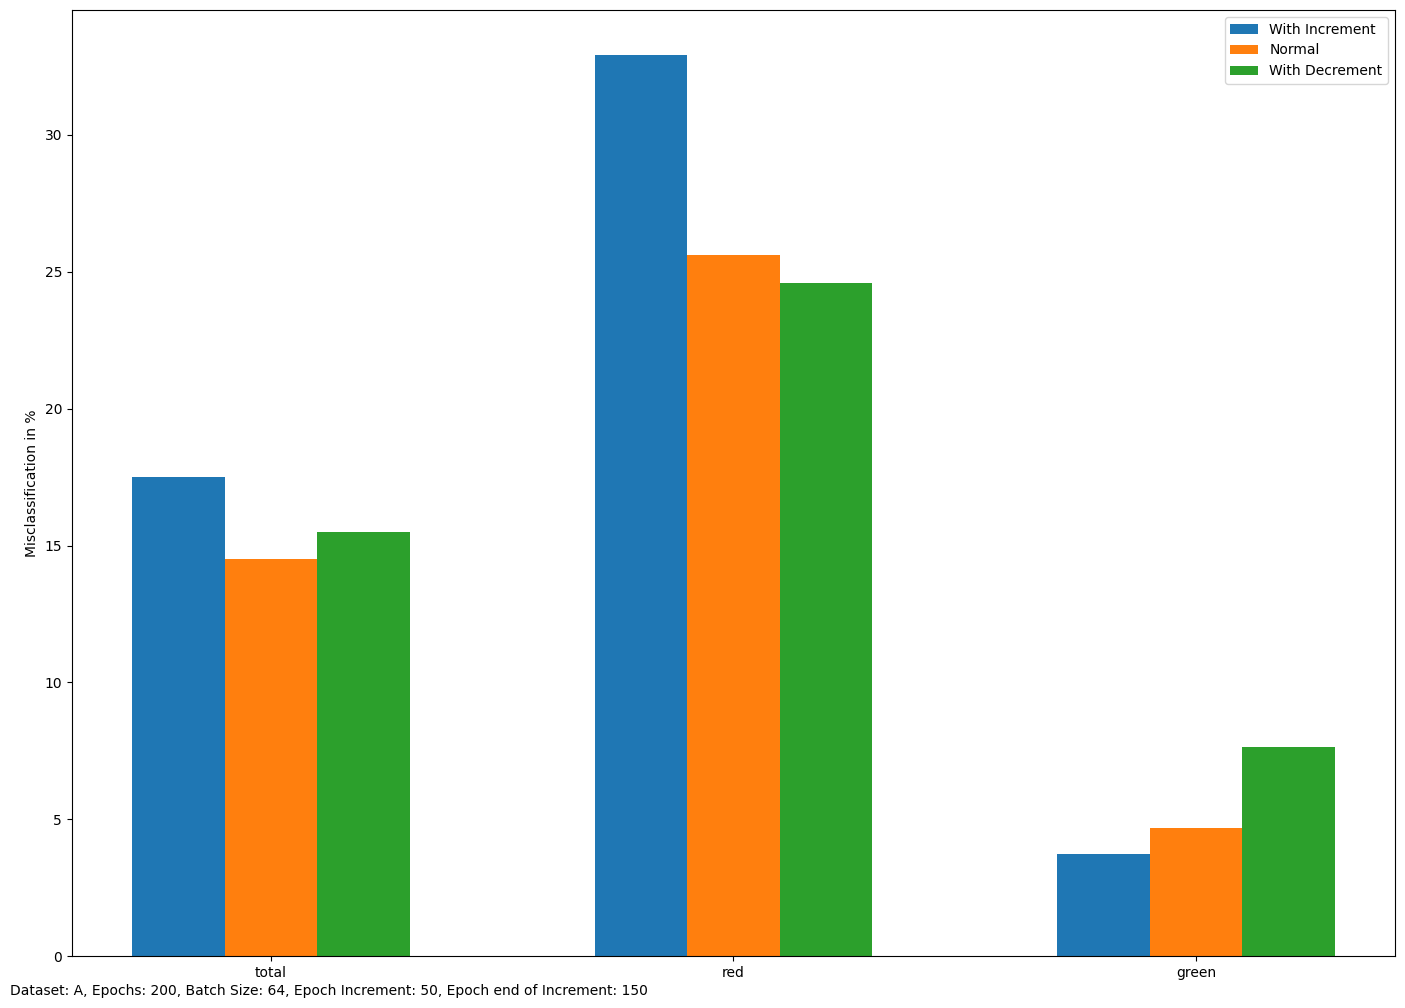

In [17]:
diffPenaltyAproach(2, 100, model_0, PENALTY, 200, 64, 50, 150)